# Solving the pressurized hole problem



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyshtools
import sys, os
sys.path.append('..')
from shelastic.shutil import SphCoord_to_CartCoord, CartCoord_to_SphCoord
from shelastic.shutil import SHCilmToVector, SHVectorToCilm, lmk2K, K2lmk

**We first set up pressure $p$, radius of the spherical void $a$, shear modulus $\mu$ and Poisson's ratio $\nu$.**

In [1]:
p = 1
a = 1
mu = 1
nu = 1./3

**Maximum size for loading coefficient matrix, $l_{J,max}$ for number of rows, $l_{K,max}$ for number of columns**

In [2]:
#### traction mode matrix info ####
modepath = '../shelastic/default_modes'
lJmax = 6 # max l degree for saving a single mode
lKmax = 3 # max cutoff l degree for modes
LJ = (lJmax+1)**2
LK = (lKmax+1)**2

**Spherical and Cartesian coordinates of surface mesh on the void**

In [2]:
#### create meshgrid for evaluation ####
## DH2 mesh
#Ngrid = 100
#theta = (np.arange(0,Ngrid)+0.0)/Ngrid*(np.pi)
#phi = (np.arange(0,2*Ngrid)+0.0)/(2*Ngrid)*(2*np.pi)
## GLQ mesh
latglq, longlq = pyshtools.expand.GLQGridCoord(lJmax)
theta = np.deg2rad(90 - latglq)
phi = np.deg2rad(longlq)

THETA,PHI = np.meshgrid(theta, phi)
R = np.ones_like(THETA)
X, Y, Z = SphCoord_to_CartCoord(R, THETA, PHI)
N = -np.stack((X/R, Y/R, Z/R), axis=-1)

In [3]:
#### generate boundary condition ####
S_inf = np.zeros(X.shape+(3, 3))
S_inf[...,0,0] = p
S_inf[...,1,1] = p
S_inf[...,2,2] = p

T_inf = np.einsum('ijkl,ijl->ijk', S_inf, N)
T_usr_mesh = T_inf.astype(np.complex)
T_usr_vec = np.empty((3, LJ), dtype=np.complex)
for k in range(3):
    T_usr_grid = pyshtools.SHGrid.from_array(T_usr_mesh[...,k].T, grid='GLQ')
    T_usr_cilm = T_usr_grid.expand()
    T_usr_vec[k, :] = SHCilmToVector(T_usr_cilm.to_array(), lmax = lJmax)
T_usr_vec = T_usr_vec.flatten()

In [4]:
#### load the full and sub matrix ####
import scipy.sparse as spm
from scipy.io import loadmat, savemat
from shelastic.shbv import generate_submat
import time

ticT = time.time()
shtype = 'irr'
Tmodes = loadmat(os.path.join(modepath, 'Tmodes.mat'))
Cmat = generate_submat(Tmodes, mu, nu, lKmax, lJmax, shtype=shtype)
Umodes = loadmat(os.path.join(modepath, 'Umodes.mat'))
Dmat = generate_submat(Umodes, mu, nu, lKmax, lJmax, shtype=shtype)
Smodes = loadmat(os.path.join(modepath, 'Smodes.mat'))
Smodes = generate_submat(Smodes, mu, nu, lKmax, lJmax, shtype=shtype)
tocT = time.time()
print('Time for loading SH modes: %.4fs'%(tocT-ticT))

Time for loading SH modes: 1.9987s


In [5]:
from shelastic.shbv import print_SH_mode
from scipy.sparse.linalg import lsqr

ticA = time.time()
A = lsqr(Cmat, T_usr_vec.T)
tocA = time.time()
print('Residual:', A[3], 'Time:', tocA-ticA)
A_sol = np.zeros_like(A[0])
A_sol[np.abs(A[0]) > 1e-8] = A[0][np.abs(A[0]) > 1e-8]
print('Solution:', A_sol.size)
index_sol = print_SH_mode(A_sol, m_dir=3)

Residual: 1.0422841565110273e-15 Time: 0.0010693073272705078
Solution: 48
index: 1 (1, -1, 0) coeff: (0.05567022142689044+8.396035419845377e-18j)
index: 3 (1, 1, 0) coeff: (-0.055670221426890446+1.2339625481390787e-17j)
index: 17 (1, -1, 1) coeff: (-1.27801084382471e-17+0.05567022142689044j)
index: 19 (1, 1, 1) coeff: (8.830873854617681e-18+0.055670221426890446j)
index: 34 (1, 0, 2) coeff: (-0.07872958216222174+7.065439344349434e-19j)


In [6]:
# Test the energy
from shelastic.shbv import fast_energy_solution
from shelastic.shutil import plotfv

# orthogonization of the spherical harmonics
E1 = -fast_energy_solution(A_sol, Dmat, Cmat)
print('energy from SH method:', E1)

# direct evaluation
uvec = Dmat.dot(A_sol)
Ku = np.nonzero(np.abs(uvec) > 1e-8)[0]
Kt = np.nonzero(np.abs(T_usr_vec) > 1e-8)[0]
np.set_printoptions(precision=4)
print('uvec:')
print('K', Ku)
print(np.array(K2lmk(Ku, lJmax)))
print('ulmk', uvec[Ku])
print('Tvec:')
print('K', Kt)
print(np.array(K2lmk(Kt, lJmax)))
print('Tlmk', T_usr_vec[Kt])

cvec = uvec.reshape(3, -1)
Tcvec= Cmat.dot(A_sol).reshape(3, -1)
Tmesh = np.zeros_like(T_inf)
umesh = np.zeros_like(T_inf)
for k in range(3):
    ucoeff = pyshtools.SHCoeffs.from_array(SHVectorToCilm(cvec[k, :]))
    ugrid = ucoeff.expand('GLQ')
    umesh[..., k] = ugrid.to_array().T.real
    Tcoeff = pyshtools.SHCoeffs.from_array(SHVectorToCilm(Tcvec[k, :]))
    Tgrid = Tcoeff.expand('GLQ')
    Tmesh[..., k] = Tgrid.to_array().T.real

dt = np.gradient(THETA, axis=1)
dp = np.gradient(PHI, axis=0)
dA = np.sin(THETA)*dp*dt
E2 = (1/2 *np.sum(umesh*Tmesh, axis=-1)*dA).sum()

print('numerical energy:', E2)
plt.show()

energy from SH method: 1.5707963267948977
uvec:
K [  1   3  50  52 100]
[[ 1  1  1  1  1]
 [-1  1 -1  1  0]
 [ 0  0  1  1  2]]
ulmk [-1.0206e-01-1.0513e-17j  1.0206e-01-1.5939e-17j  1.6500e-17-1.0206e-01j
 -1.3973e-17-1.0206e-01j  1.4434e-01-1.4994e-18j]
Tvec:
K [  1   3  50  52 100]
[[ 1  1  1  1  1]
 [-1  1 -1  1  0]
 [ 0  0  1  1  2]]
Tlmk [ 4.0825e-01+3.4369e-17j -4.0825e-01+3.4369e-17j -1.6608e-18+4.0825e-01j
  1.6608e-18+4.0825e-01j -5.7735e-01+0.0000e+00j]
numerical energy: -1.5718420067430083


## Verify the SH method with FEM

In [7]:
from shelastic.shbv import fast_stress_solution

x_grid = np.linspace(1.01, 4.5)
Y, X, Z = np.meshgrid(x_grid, [0, ], [0, ])
R, THETA, PHI = CartCoord_to_SphCoord(X,Y,Z)

tic = time.time()
sigma_tot = fast_stress_solution(A_sol, X, Y, Z, Smodes, lKmax, lJmax)
toc = time.time()
print(sigma_tot.shape, toc-tic)

(1, 50, 1, 3, 3) 0.044354915618896484


(30, 2) (19, 2)


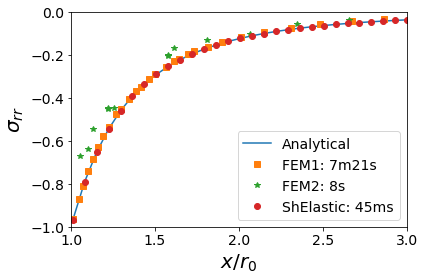

In [8]:
# FEM result
FEM_1 = loadmat('../testdata/uniform_pressure_case_1.mat')['M'][2::4,:]
FEM_2 = loadmat('../testdata/uniform_pressure_case_2.mat')['M']

print(FEM_1.shape, FEM_2.shape)#, FEM.shape)

C = -p * a**3
D = 0
srr = C/R**3 + D

plt.plot(x_grid, srr.flatten(), label='Analytical')
plt.plot(FEM_1[:, 0],-FEM_1[:, 1], 's', label='FEM1: 7m21s')
plt.plot(FEM_2[:, 0],-FEM_2[:, 1], '*',  label='FEM2: 8s')
total_time = 1000*(toc-tic+tocA-ticA)
plt.plot(x_grid, sigma_tot[...,1,1].flatten(), 'o', label='ShElastic: %.0fms' % total_time)
plt.xlim(1, 3)
plt.ylim(-1, 0)
plt.tick_params(labelsize=14)
plt.xlabel(r'$x/r_0$', fontsize=20)
plt.ylabel(r'$\sigma_{rr}$', fontsize=20)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig('../figures/case1-result.png', dpi=1000, transparent=True)
plt.show()